In [28]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, activations, out_dim):
        super().__init__()
        layers, dims = [], [in_dim] + hidden_dims
        for i, h in enumerate(hidden_dims):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            act = activations[i].lower()
            if   act == 'relu':     layers.append(nn.ReLU())
            elif act == 'tanh':     layers.append(nn.Tanh())
            elif act == 'sigmoid':  layers.append(nn.Sigmoid())
            elif act == 'softplus': layers.append(nn.Softplus())
            else: raise ValueError(f"Unknown activation '{activations[i]}'")
        layers.append(nn.Linear(dims[-1], out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def cross_validate_mlp(
    csv_path: str,
    k_folds: int,
    layer_dims: list[int],
    activations: list[str],
    epochs: int,
    lr: float,
    weghtdecay: float,
    batch_size: int,
    random_state: int,
    loss_type: str = 'mse'
):
    """
    Loads data from `csv_path`, treats the first two columns as targets and the rest
    as inputs (with the last column being a 3-way categorical), then runs K-fold
    cross-validation of an MLP regressor.

    Returns:
        fold_results: list of dicts with per‐fold true/pred arrays
        histories:     list of tuples (train_losses, val_losses, train_r2s, val_r2s)
        models:        list of trained torch models (one per fold)
        norms:         dict with x/y means & stds for un‐normalizing
        feature_names: list of input feature names after one-hot encoding
    """
    # reproducibility
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    # device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 1) load
    df = pd.read_csv(csv_path)

    # 2) split outputs & inputs
    output_cols = df.columns[:2].tolist()
    input_cols  = df.columns[2:].tolist()
    num_cols    = input_cols[:-1]
    cat_col     = input_cols[-1]

    # 3) prepare & normalize y
    y_np     = df[output_cols].to_numpy(dtype=np.float32)
    y_mean   = y_np.mean(axis=0, keepdims=True)
    y_std    = y_np.std(axis=0, keepdims=True)
    y_std[y_std == 0] = 1.0
    y_norm   = (y_np - y_mean) / y_std

    # 4) prepare X
    X = df[num_cols].astype(float).copy()
    x_mean = X.mean()
    x_std  = X.std().replace(0, 1.0)
    X = (X - x_mean) / x_std

    # one-hot encode the last column
    dummies = pd.get_dummies(df[cat_col].astype(str), prefix=cat_col)
    X = pd.concat([X, dummies], axis=1)

    feature_names = X.columns.tolist()
    X_np = X.to_numpy(dtype=np.float32)

    # 5) select loss
    if loss_type == 'mse':
        loss_fn = nn.MSELoss()
    elif loss_type == 'huber':
        loss_fn = nn.SmoothL1Loss()
    else:
        raise ValueError("loss_type must be 'mse' or 'huber'")

    # 6) K-fold CV
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    fold_results, histories, models = [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np), start=1):
        X_tr, X_va = X_np[train_idx], X_np[val_idx]
        y_tr, y_va = y_norm[train_idx], y_norm[val_idx]

        ds_tr = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
        ds_va = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=batch_size)

        model = MLP(
            in_dim      = X_tr.shape[1],
            hidden_dims = layer_dims,
            activations = activations,
            out_dim     = y_tr.shape[1]
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weghtdecay
        )

        tr_losses, va_losses, tr_r2s, va_r2s = [], [], [], []

        for epoch in range(1, epochs + 1):
            # training
            model.train()
            for xb, yb in ld_tr:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss_fn(model(xb), yb).backward()
                optimizer.step()

            # evaluation
            model.eval()
            with torch.no_grad():
                p_tr = model(torch.from_numpy(X_tr).to(device)).cpu().numpy()
                p_va = model(torch.from_numpy(X_va).to(device)).cpu().numpy()

            tr_losses.append(mean_squared_error(y_tr, p_tr))
            va_losses.append(mean_squared_error(y_va, p_va))
            tr_r2s.append(r2_score(y_tr, p_tr))
            va_r2s.append(r2_score(y_va, p_va))

        print(
            f"Fold {fold}: "
            f"train MSE={tr_losses[-1]:.4f}, train R²={tr_r2s[-1]:.4f}, "
            f"val   MSE={va_losses[-1]:.4f}, val   R²={va_r2s[-1]:.4f}"
        )

        fold_results.append({
            'fold': fold,
            'train_true': y_tr,
            'train_pred': p_tr,
            'val_true':   y_va,
            'val_pred':   p_va,
        })
        histories.append((tr_losses, va_losses, tr_r2s, va_r2s))
        models.append(model)

    norms = {
        'y_mean': y_mean.flatten().tolist(),
        'y_std':  y_std.flatten().tolist(),
        'x_mean': x_mean.to_dict(),
        'x_std':  x_std.to_dict(),
    }

    return fold_results, histories, models, norms, feature_names


# First 

Fold 1: train MSE=0.4502, train R²=0.5371, val   MSE=0.3911, val   R²=0.6634
Fold 2: train MSE=0.4382, train R²=0.5759, val   MSE=0.4116, val   R²=0.4887
Fold 3: train MSE=0.4119, train R²=0.6016, val   MSE=0.5639, val   R²=0.2900
Fold 4: train MSE=0.4158, train R²=0.5624, val   MSE=0.5838, val   R²=0.5423
Fold 5: train MSE=0.4625, train R²=0.5534, val   MSE=0.4470, val   R²=0.4319
Fold 6: train MSE=0.4324, train R²=0.5657, val   MSE=0.5038, val   R²=0.5065
Fold 7: train MSE=0.4448, train R²=0.5449, val   MSE=0.5003, val   R²=0.5449


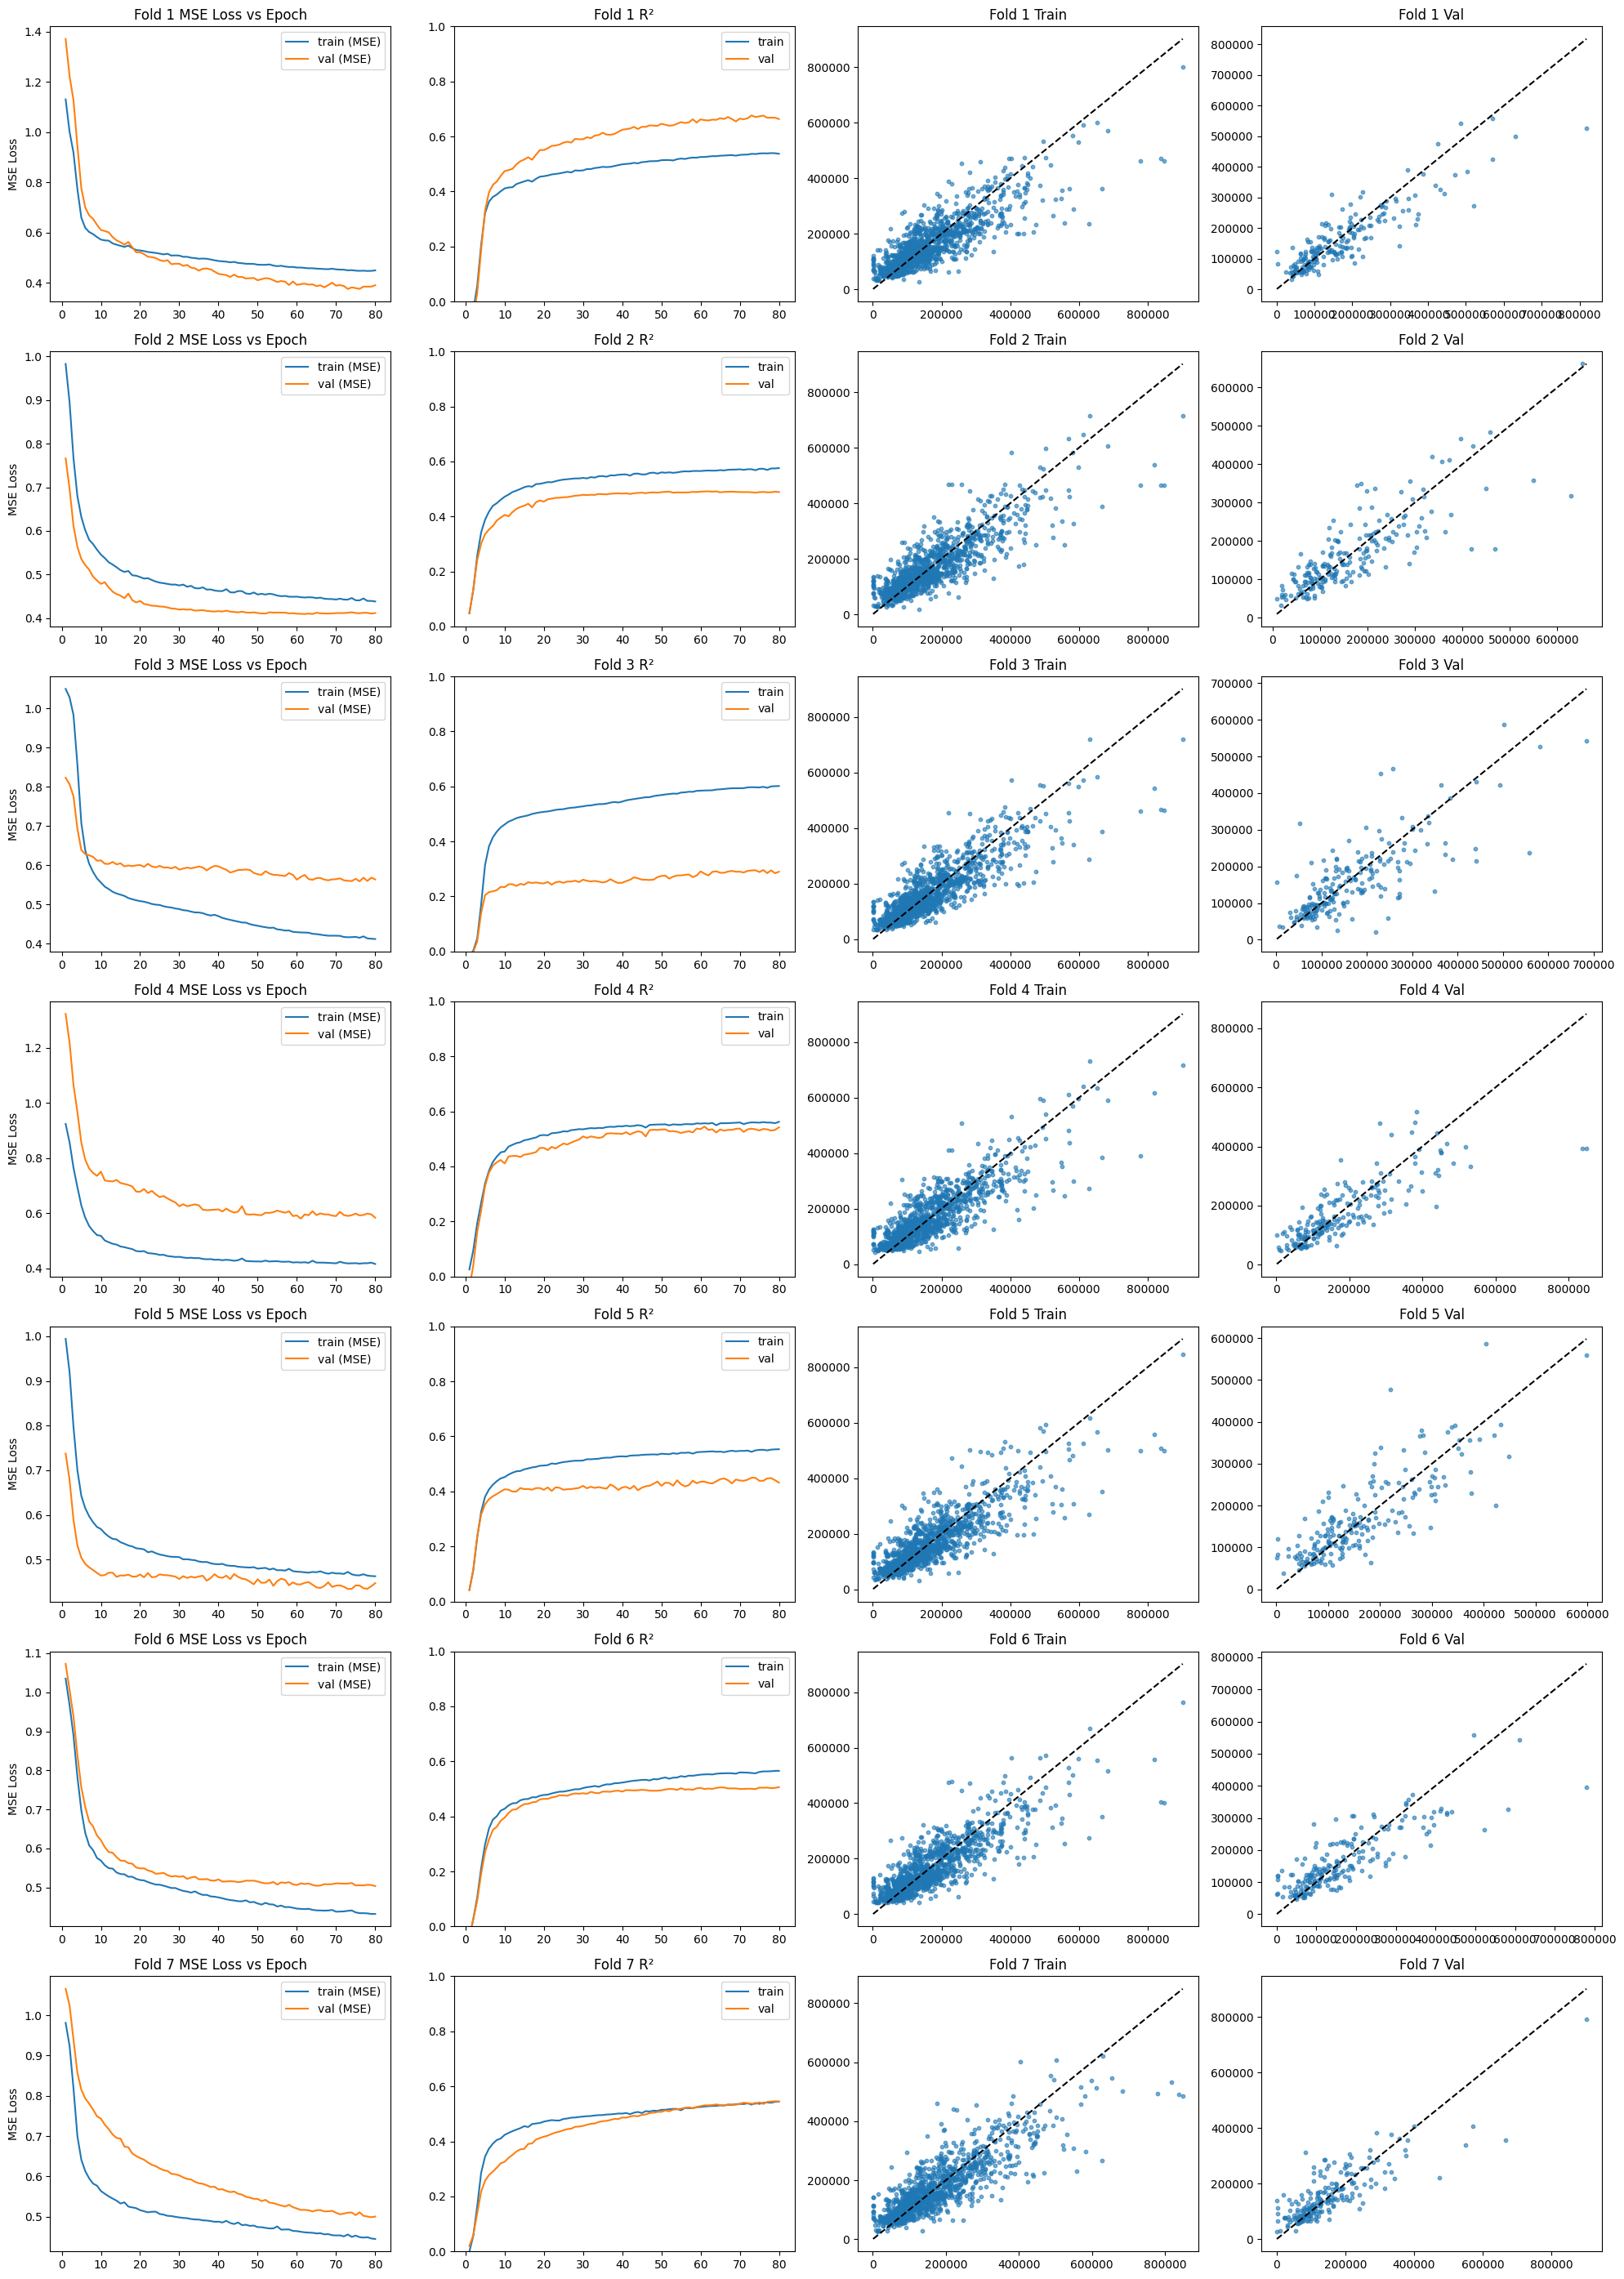

All outputs saved in ./9c89f05f/


In [29]:
import os
import uuid
import json
import torch
import matplotlib.pyplot as plt

# assume cross_validate_mlp is defined above in this script
# from my_module import cross_validate_mlp  

if __name__ == '__main__':
    # Hyperparameters
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv'
    k_folds       = 7
    layer_dims    = [4, 4]
    activations   = ['softplus', 'softplus']
    epochs        = 80
    lr            = 1e-3
    weight_decay  = 0.0
    batch_size    = 4
    random_state  = 42
    loss_type     = 'huber'  # or 'mse'

    # 1) Run cross-validation
    folds, histories, models, norms, feature_names = cross_validate_mlp(
        csv_path,
        k_folds,
        layer_dims,
        activations,
        epochs,
        lr,
        weight_decay,
        batch_size,
        random_state,
        loss_type
    )

    # 2) Create a random tag folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # 3) Save each fold's model
    for i, model in enumerate(models, start=1):
        model_path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), model_path)

    # 4) Save hyperparameters
    hyperparams = {
        "csv_path":      csv_path,
        "k_folds":       k_folds,
        "layer_dims":    layer_dims,
        "activations":   activations,
        "epochs":        epochs,
        "lr":            lr,
        "weight_decay":  weight_decay,
        "batch_size":    batch_size,
        "random_state":  random_state,
        "loss_type":     loss_type
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # 5) Save normalization constants
    safe_norms = {
        'y_mean':   norms['y_mean'],
        'y_std':    norms['y_std'],
        'x_mean':   norms['x_mean'],
        'x_std':    norms['x_std'],
    }
    with open(os.path.join(tag, f"{tag}_norms.json"), "w") as f:
        json.dump(safe_norms, f, indent=4)

    # 6) Plot diagnostics for each fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, folds)):
        ax1, ax2, ax3, ax4 = axes[i]

        # a) MSE Loss vs Epoch
        ax1.plot(range(1, epochs+1), tr_losses, label='train (MSE)')
        ax1.plot(range(1, epochs+1), va_losses, label='val (MSE)')
        ax1.set_title(f'Fold {fr["fold"]} MSE Loss vs Epoch')
        ax1.set_ylabel('MSE Loss')
        ax1.legend()


        # b) R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2s, label='train')
        ax2.plot(range(1, epochs+1), va_r2s, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R²')
        ax2.set_ylim(0, 1)        # <— force y‐axis between 0 and 1
        ax2.legend()


        # c) Train True vs Pred (rescale)
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        lim_tr = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        ax3.plot(lim_tr, lim_tr, 'k--')
        ax3.set_title(f'Fold {fr["fold"]} Train')

        # d) Val True vs Pred (rescale)
        yt_va = fr['val_true'] * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred'] * norms['y_std'] + norms['y_mean']
        lim_va = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        ax4.plot(lim_va, lim_va, 'k--')
        ax4.set_title(f'Fold {fr["fold"]} Val')

    plt.tight_layout()
    # 7) Save diagnostics plot
    plt.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs saved in ./{tag}/")


# second

Fold 1: train MSE=0.1762, train R²=0.8188, val   MSE=0.3502, val   R²=0.6985
Fold 2: train MSE=0.1849, train R²=0.8210, val   MSE=0.4495, val   R²=0.4379
Fold 3: train MSE=0.2006, train R²=0.8059, val   MSE=0.3907, val   R²=0.5080
Fold 4: train MSE=0.1860, train R²=0.8042, val   MSE=0.5280, val   R²=0.5845
Fold 5: train MSE=0.1823, train R²=0.8239, val   MSE=0.2971, val   R²=0.6215
Fold 6: train MSE=0.1720, train R²=0.8273, val   MSE=0.3192, val   R²=0.6870
Fold 7: train MSE=0.1576, train R²=0.8387, val   MSE=0.5387, val   R²=0.5103


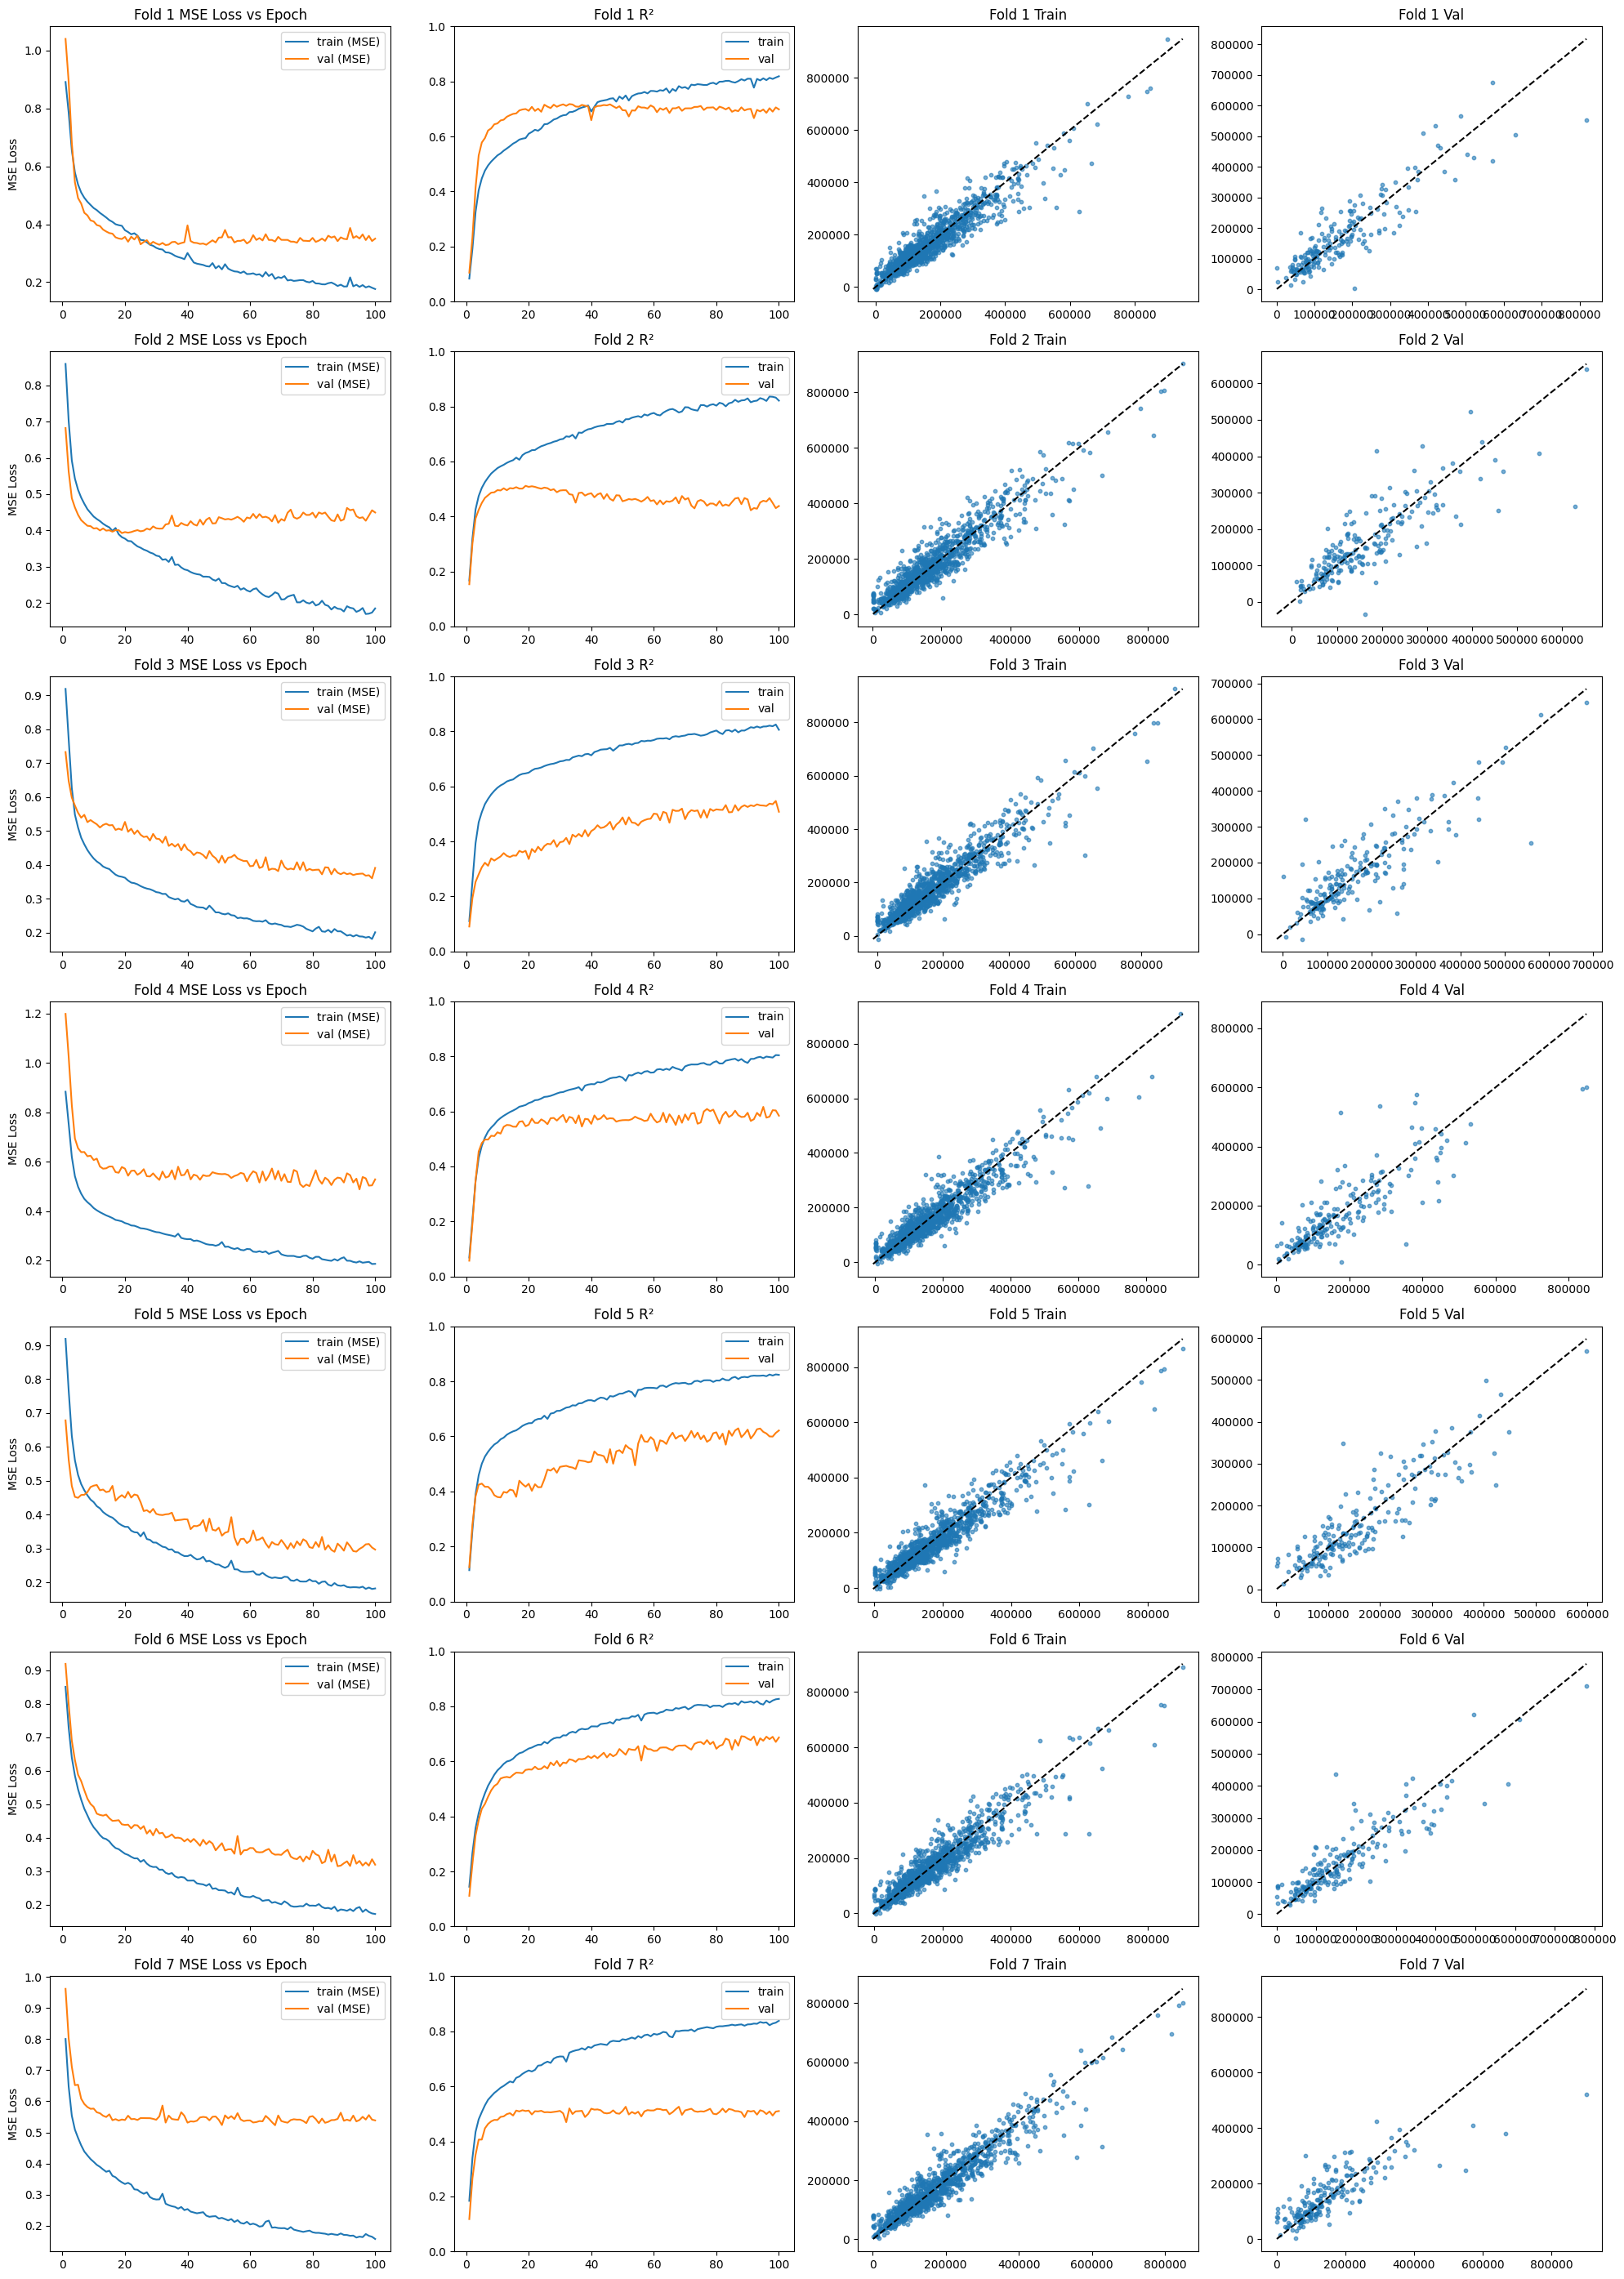

All outputs saved in ./91050661/


In [30]:
import os
import uuid
import json
import torch
import matplotlib.pyplot as plt

# assume cross_validate_mlp is defined above in this script
# from my_module import cross_validate_mlp  

if __name__ == '__main__':
    # Hyperparameters
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv'
    k_folds       = 7
    layer_dims    = [64, 32]
    activations   = ['relu', 'relu']
    epochs        = 100
    lr            = 1e-3
    weight_decay  = 1e-4
    batch_size    = 32
    random_state  = 42
    loss_type     = 'mse' 

    # 1) Run cross-validation
    folds, histories, models, norms, feature_names = cross_validate_mlp(
        csv_path,
        k_folds,
        layer_dims,
        activations,
        epochs,
        lr,
        weight_decay,
        batch_size,
        random_state,
        loss_type
    )

    # 2) Create a random tag folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # 3) Save each fold's model
    for i, model in enumerate(models, start=1):
        model_path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), model_path)

    # 4) Save hyperparameters
    hyperparams = {
        "csv_path":      csv_path,
        "k_folds":       k_folds,
        "layer_dims":    layer_dims,
        "activations":   activations,
        "epochs":        epochs,
        "lr":            lr,
        "weight_decay":  weight_decay,
        "batch_size":    batch_size,
        "random_state":  random_state,
        "loss_type":     loss_type
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # 5) Save normalization constants
    safe_norms = {
        'y_mean':   norms['y_mean'],
        'y_std':    norms['y_std'],
        'x_mean':   norms['x_mean'],
        'x_std':    norms['x_std'],
    }
    with open(os.path.join(tag, f"{tag}_norms.json"), "w") as f:
        json.dump(safe_norms, f, indent=4)

    # 6) Plot diagnostics for each fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, folds)):
        ax1, ax2, ax3, ax4 = axes[i]

        # a) MSE Loss vs Epoch
        ax1.plot(range(1, epochs+1), tr_losses, label='train (MSE)')
        ax1.plot(range(1, epochs+1), va_losses, label='val (MSE)')
        ax1.set_title(f'Fold {fr["fold"]} MSE Loss vs Epoch')
        ax1.set_ylabel('MSE Loss')
        ax1.legend()


        # b) R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2s, label='train')
        ax2.plot(range(1, epochs+1), va_r2s, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R²')
        ax2.set_ylim(0, 1)        # <— force y‐axis between 0 and 1
        ax2.legend()


        # c) Train True vs Pred (rescale)
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        lim_tr = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        ax3.plot(lim_tr, lim_tr, 'k--')
        ax3.set_title(f'Fold {fr["fold"]} Train')

        # d) Val True vs Pred (rescale)
        yt_va = fr['val_true'] * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred'] * norms['y_std'] + norms['y_mean']
        lim_va = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        ax4.plot(lim_va, lim_va, 'k--')
        ax4.set_title(f'Fold {fr["fold"]} Val')

    plt.tight_layout()
    # 7) Save diagnostics plot
    plt.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs saved in ./{tag}/")


## Second:Batch size increase
Reduced learning rate DOES NOT WORK

Fold 1: train MSE=0.1971, train R²=0.7973, val   MSE=0.3511, val   R²=0.6978
Fold 2: train MSE=0.1971, train R²=0.8092, val   MSE=0.4191, val   R²=0.4769
Fold 3: train MSE=0.2154, train R²=0.7916, val   MSE=0.4054, val   R²=0.4883
Fold 4: train MSE=0.2093, train R²=0.7797, val   MSE=0.5369, val   R²=0.5771
Fold 5: train MSE=0.2092, train R²=0.7978, val   MSE=0.3323, val   R²=0.5786
Fold 6: train MSE=0.1941, train R²=0.8051, val   MSE=0.3291, val   R²=0.6766
Fold 7: train MSE=0.1847, train R²=0.8109, val   MSE=0.5498, val   R²=0.5023


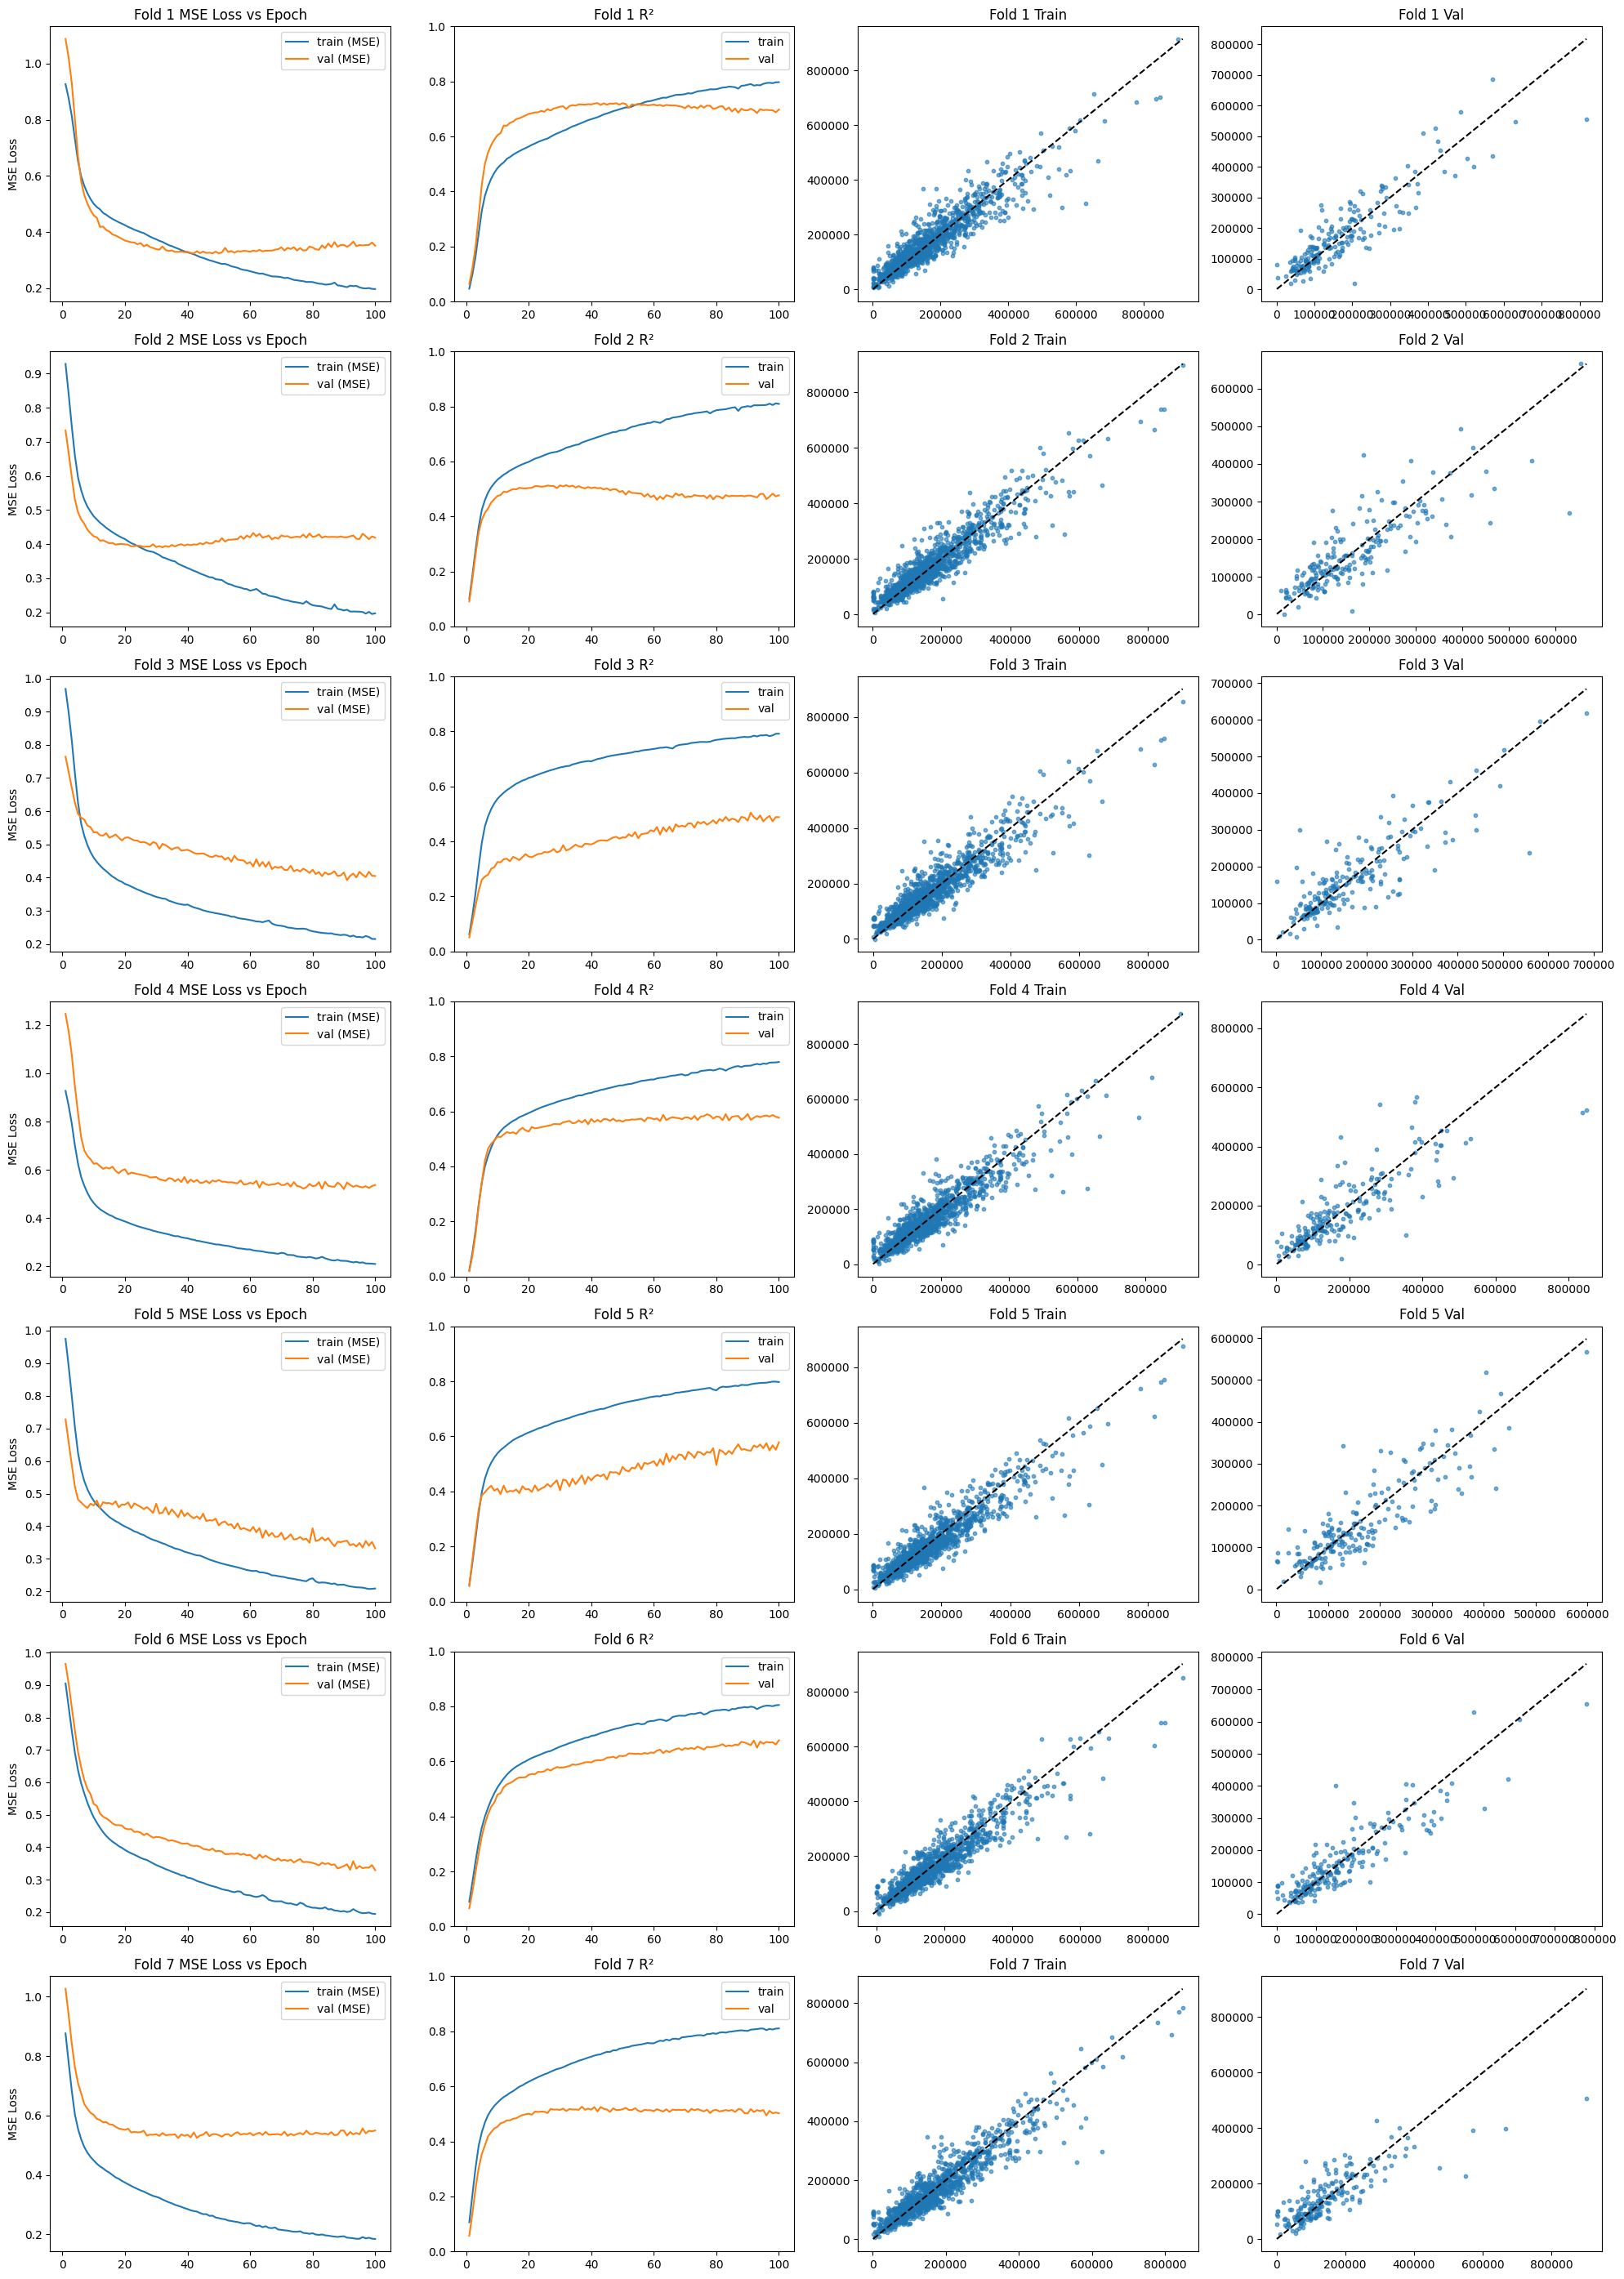

All outputs saved in ./2ee3b399/


In [33]:
import os
import uuid
import json
import torch
import matplotlib.pyplot as plt

# assume cross_validate_mlp is defined above in this script
# from my_module import cross_validate_mlp  

if __name__ == '__main__':
    # Hyperparameters
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv'
    k_folds       = 7
    layer_dims    = [64, 32]
    activations   = ['relu', 'relu']
    epochs        = 100
    lr            = 1e-3
    weight_decay  = 1e-4
    batch_size    = 64
    random_state  = 42
    loss_type     = 'mse' 

    # 1) Run cross-validation
    folds, histories, models, norms, feature_names = cross_validate_mlp(
        csv_path,
        k_folds,
        layer_dims,
        activations,
        epochs,
        lr,
        weight_decay,
        batch_size,
        random_state,
        loss_type
    )

    # 2) Create a random tag folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # 3) Save each fold's model
    for i, model in enumerate(models, start=1):
        model_path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), model_path)

    # 4) Save hyperparameters
    hyperparams = {
        "csv_path":      csv_path,
        "k_folds":       k_folds,
        "layer_dims":    layer_dims,
        "activations":   activations,
        "epochs":        epochs,
        "lr":            lr,
        "weight_decay":  weight_decay,
        "batch_size":    batch_size,
        "random_state":  random_state,
        "loss_type":     loss_type
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # 5) Save normalization constants
    safe_norms = {
        'y_mean':   norms['y_mean'],
        'y_std':    norms['y_std'],
        'x_mean':   norms['x_mean'],
        'x_std':    norms['x_std'],
    }
    with open(os.path.join(tag, f"{tag}_norms.json"), "w") as f:
        json.dump(safe_norms, f, indent=4)

    # 6) Plot diagnostics for each fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, folds)):
        ax1, ax2, ax3, ax4 = axes[i]

        # a) MSE Loss vs Epoch
        ax1.plot(range(1, epochs+1), tr_losses, label='train (MSE)')
        ax1.plot(range(1, epochs+1), va_losses, label='val (MSE)')
        ax1.set_title(f'Fold {fr["fold"]} MSE Loss vs Epoch')
        ax1.set_ylabel('MSE Loss')
        ax1.legend()


        # b) R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2s, label='train')
        ax2.plot(range(1, epochs+1), va_r2s, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R²')
        ax2.set_ylim(0, 1)        # <— force y‐axis between 0 and 1
        ax2.legend()


        # c) Train True vs Pred (rescale)
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        lim_tr = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        ax3.plot(lim_tr, lim_tr, 'k--')
        ax3.set_title(f'Fold {fr["fold"]} Train')

        # d) Val True vs Pred (rescale)
        yt_va = fr['val_true'] * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred'] * norms['y_std'] + norms['y_mean']
        lim_va = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        ax4.plot(lim_va, lim_va, 'k--')
        ax4.set_title(f'Fold {fr["fold"]} Val')

    plt.tight_layout()
    # 7) Save diagnostics plot
    plt.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs saved in ./{tag}/")


# Third

Fold 1: train MSE=0.1458, train R²=0.8500, val   MSE=0.3638, val   R²=0.6868
Fold 2: train MSE=0.1612, train R²=0.8440, val   MSE=0.3959, val   R²=0.5083
Fold 3: train MSE=0.1728, train R²=0.8328, val   MSE=0.3181, val   R²=0.5985
Fold 4: train MSE=0.1529, train R²=0.8390, val   MSE=0.5185, val   R²=0.5901
Fold 5: train MSE=0.1679, train R²=0.8379, val   MSE=0.3830, val   R²=0.5148
Fold 6: train MSE=0.1633, train R²=0.8360, val   MSE=0.2914, val   R²=0.7138
Fold 7: train MSE=0.1546, train R²=0.8419, val   MSE=0.5951, val   R²=0.4584


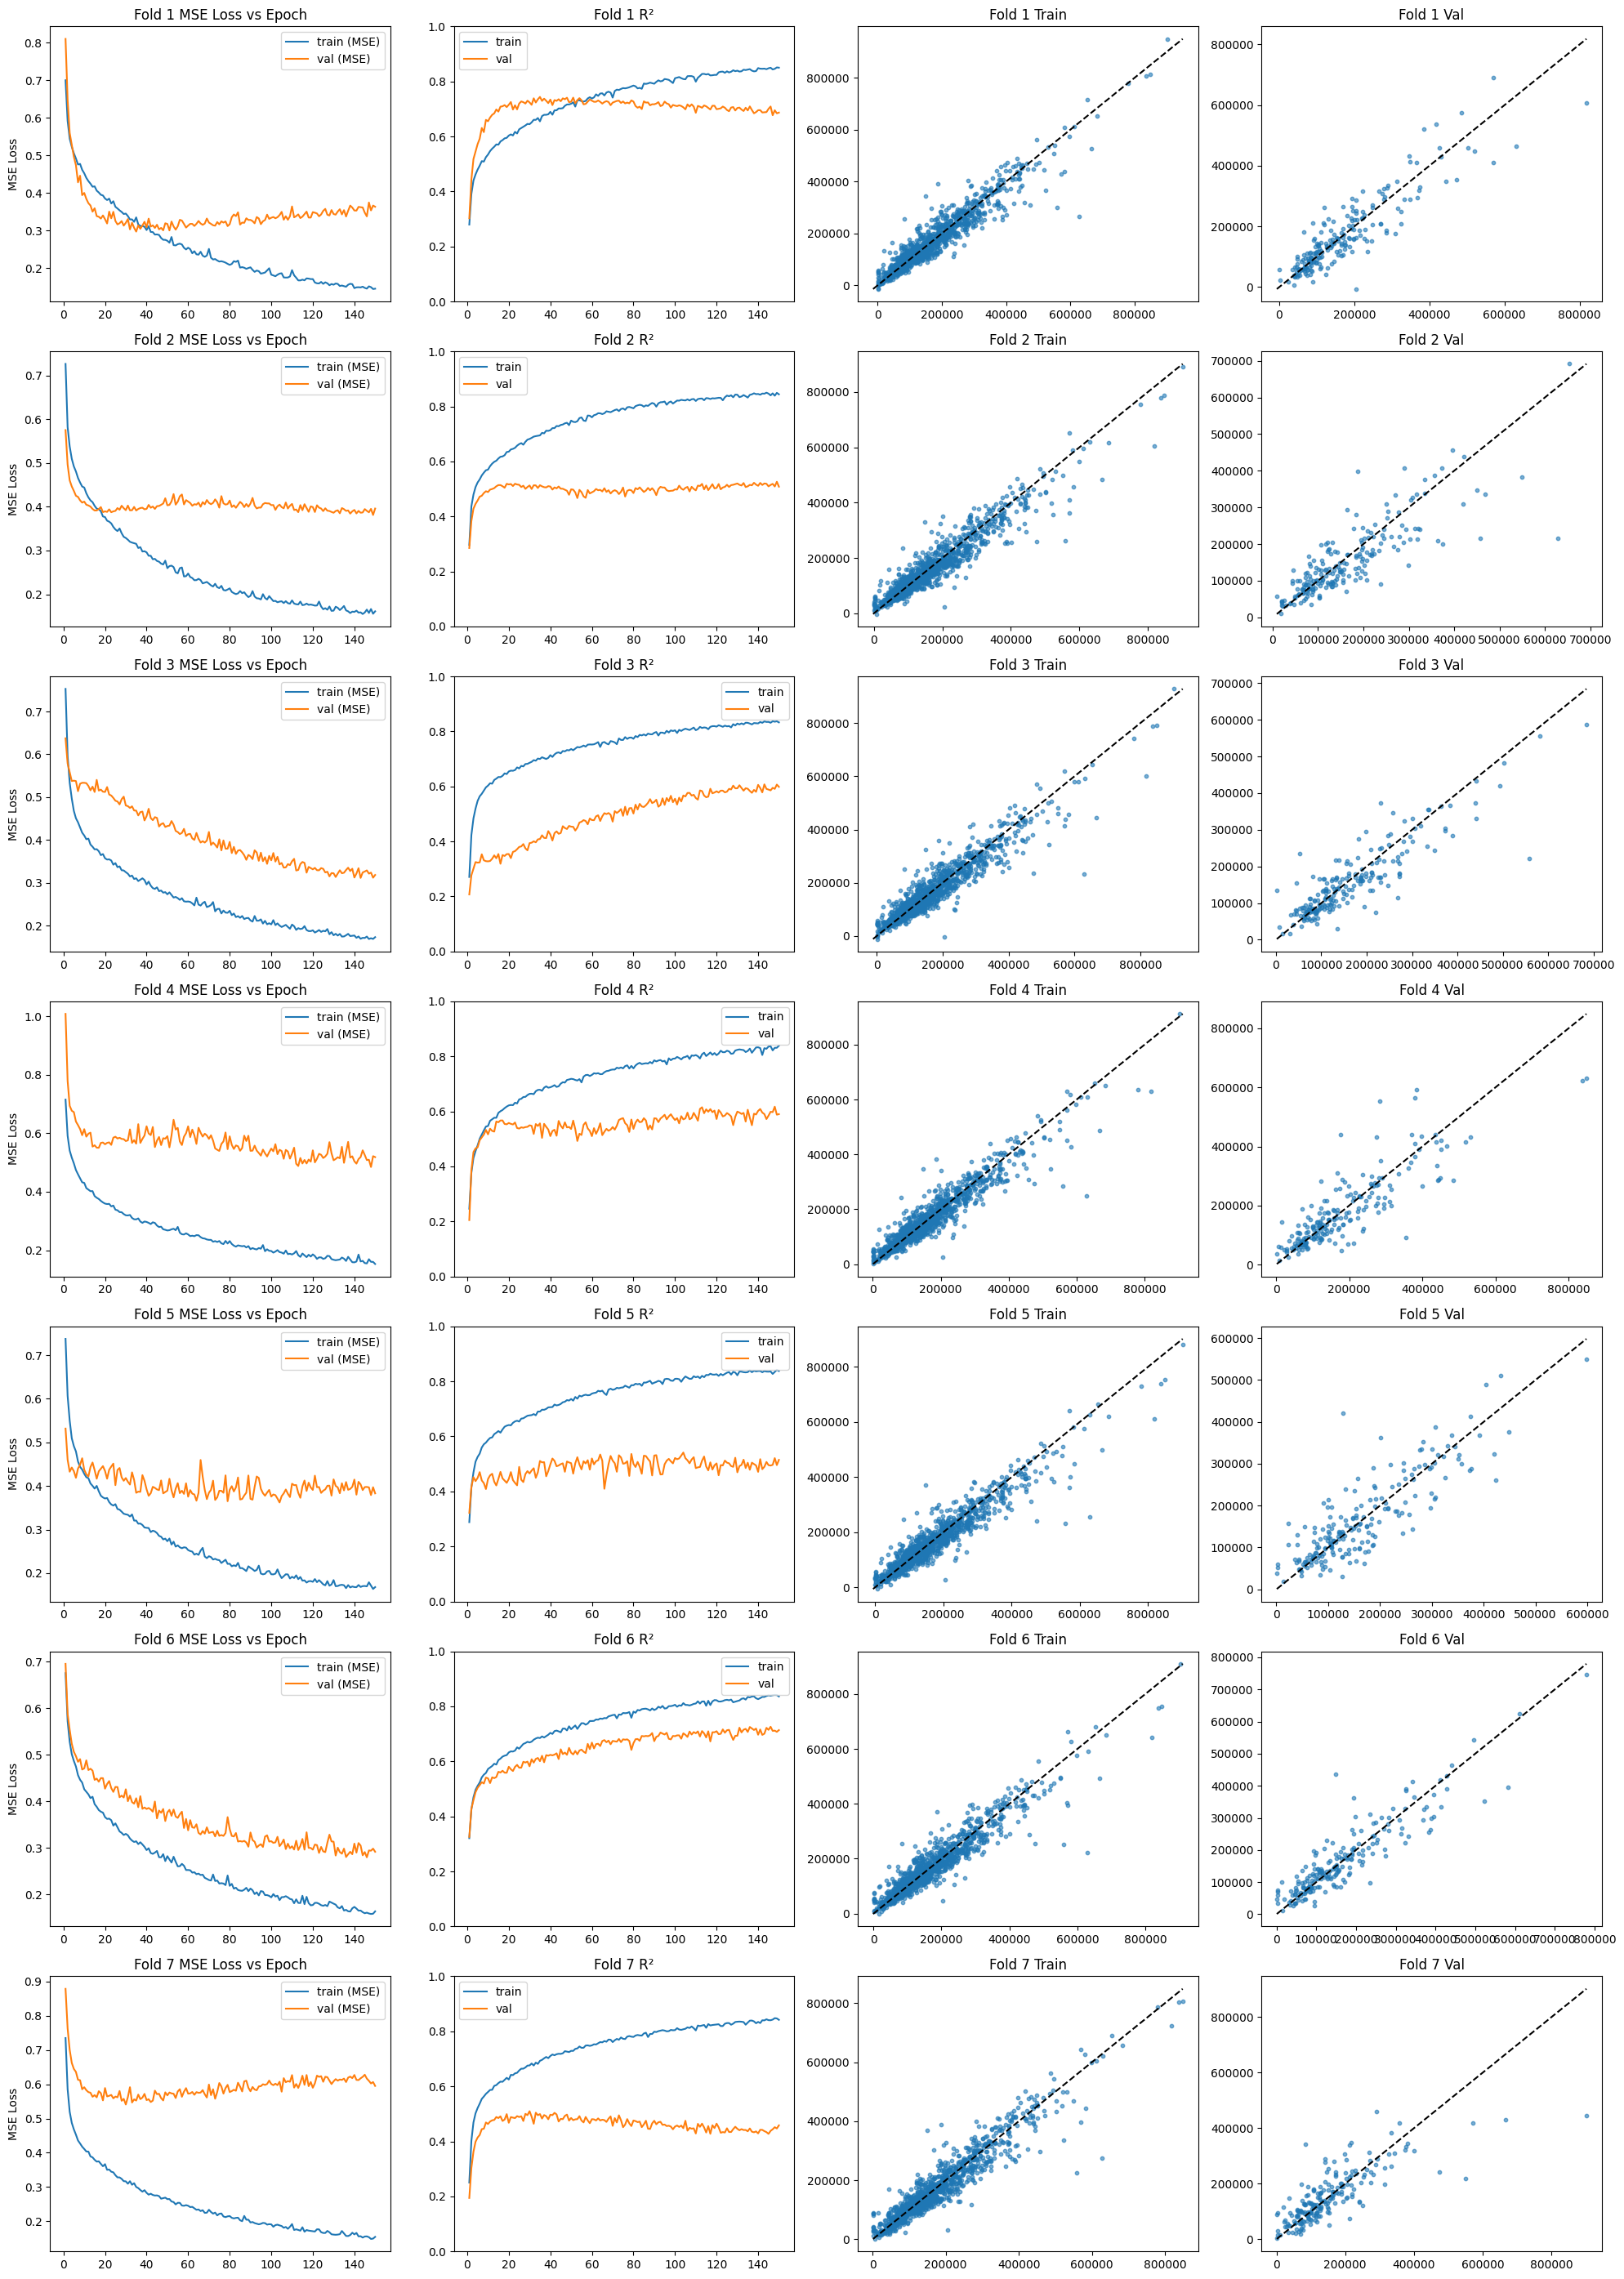

All outputs saved in ./79d1409e/


In [34]:
import os
import uuid
import json
import torch
import matplotlib.pyplot as plt

# assume cross_validate_mlp is defined above in this script
# from my_module import cross_validate_mlp  

if __name__ == '__main__':
    # Hyperparameters
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv'
    k_folds       = 7
    layer_dims    = [128, 64]
    activations   = ['tanh', 'relu']
    epochs        = 150
    lr            = 5e-4
    weight_decay  = 5e-5
    batch_size    = 16
    random_state  = 42
    loss_type     = 'huber' 

    # 1) Run cross-validation
    folds, histories, models, norms, feature_names = cross_validate_mlp(
        csv_path,
        k_folds,
        layer_dims,
        activations,
        epochs,
        lr,
        weight_decay,
        batch_size,
        random_state,
        loss_type
    )

    # 2) Create a random tag folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # 3) Save each fold's model
    for i, model in enumerate(models, start=1):
        model_path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), model_path)

    # 4) Save hyperparameters
    hyperparams = {
        "csv_path":      csv_path,
        "k_folds":       k_folds,
        "layer_dims":    layer_dims,
        "activations":   activations,
        "epochs":        epochs,
        "lr":            lr,
        "weight_decay":  weight_decay,
        "batch_size":    batch_size,
        "random_state":  random_state,
        "loss_type":     loss_type
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # 5) Save normalization constants
    safe_norms = {
        'y_mean':   norms['y_mean'],
        'y_std':    norms['y_std'],
        'x_mean':   norms['x_mean'],
        'x_std':    norms['x_std'],
    }
    with open(os.path.join(tag, f"{tag}_norms.json"), "w") as f:
        json.dump(safe_norms, f, indent=4)

    # 6) Plot diagnostics for each fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, folds)):
        ax1, ax2, ax3, ax4 = axes[i]

        # a) MSE Loss vs Epoch
        ax1.plot(range(1, epochs+1), tr_losses, label='train (MSE)')
        ax1.plot(range(1, epochs+1), va_losses, label='val (MSE)')
        ax1.set_title(f'Fold {fr["fold"]} MSE Loss vs Epoch')
        ax1.set_ylabel('MSE Loss')
        ax1.legend()


        # b) R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2s, label='train')
        ax2.plot(range(1, epochs+1), va_r2s, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R²')
        ax2.set_ylim(0, 1)        # <— force y‐axis between 0 and 1
        ax2.legend()


        # c) Train True vs Pred (rescale)
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        lim_tr = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        ax3.plot(lim_tr, lim_tr, 'k--')
        ax3.set_title(f'Fold {fr["fold"]} Train')

        # d) Val True vs Pred (rescale)
        yt_va = fr['val_true'] * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred'] * norms['y_std'] + norms['y_mean']
        lim_va = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        ax4.plot(lim_va, lim_va, 'k--')
        ax4.set_title(f'Fold {fr["fold"]} Val')

    plt.tight_layout()
    # 7) Save diagnostics plot
    plt.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs saved in ./{tag}/")


## Third:weght decay incread

 batch and lr not helped

Fold 1: train MSE=0.1506, train R²=0.8451, val   MSE=0.3666, val   R²=0.6844
Fold 2: train MSE=0.1671, train R²=0.8382, val   MSE=0.3976, val   R²=0.5059
Fold 3: train MSE=0.1741, train R²=0.8316, val   MSE=0.3240, val   R²=0.5917
Fold 4: train MSE=0.1578, train R²=0.8338, val   MSE=0.5074, val   R²=0.5987
Fold 5: train MSE=0.1746, train R²=0.8314, val   MSE=0.3700, val   R²=0.5322
Fold 6: train MSE=0.1696, train R²=0.8297, val   MSE=0.2989, val   R²=0.7062
Fold 7: train MSE=0.1656, train R²=0.8306, val   MSE=0.5783, val   R²=0.4749


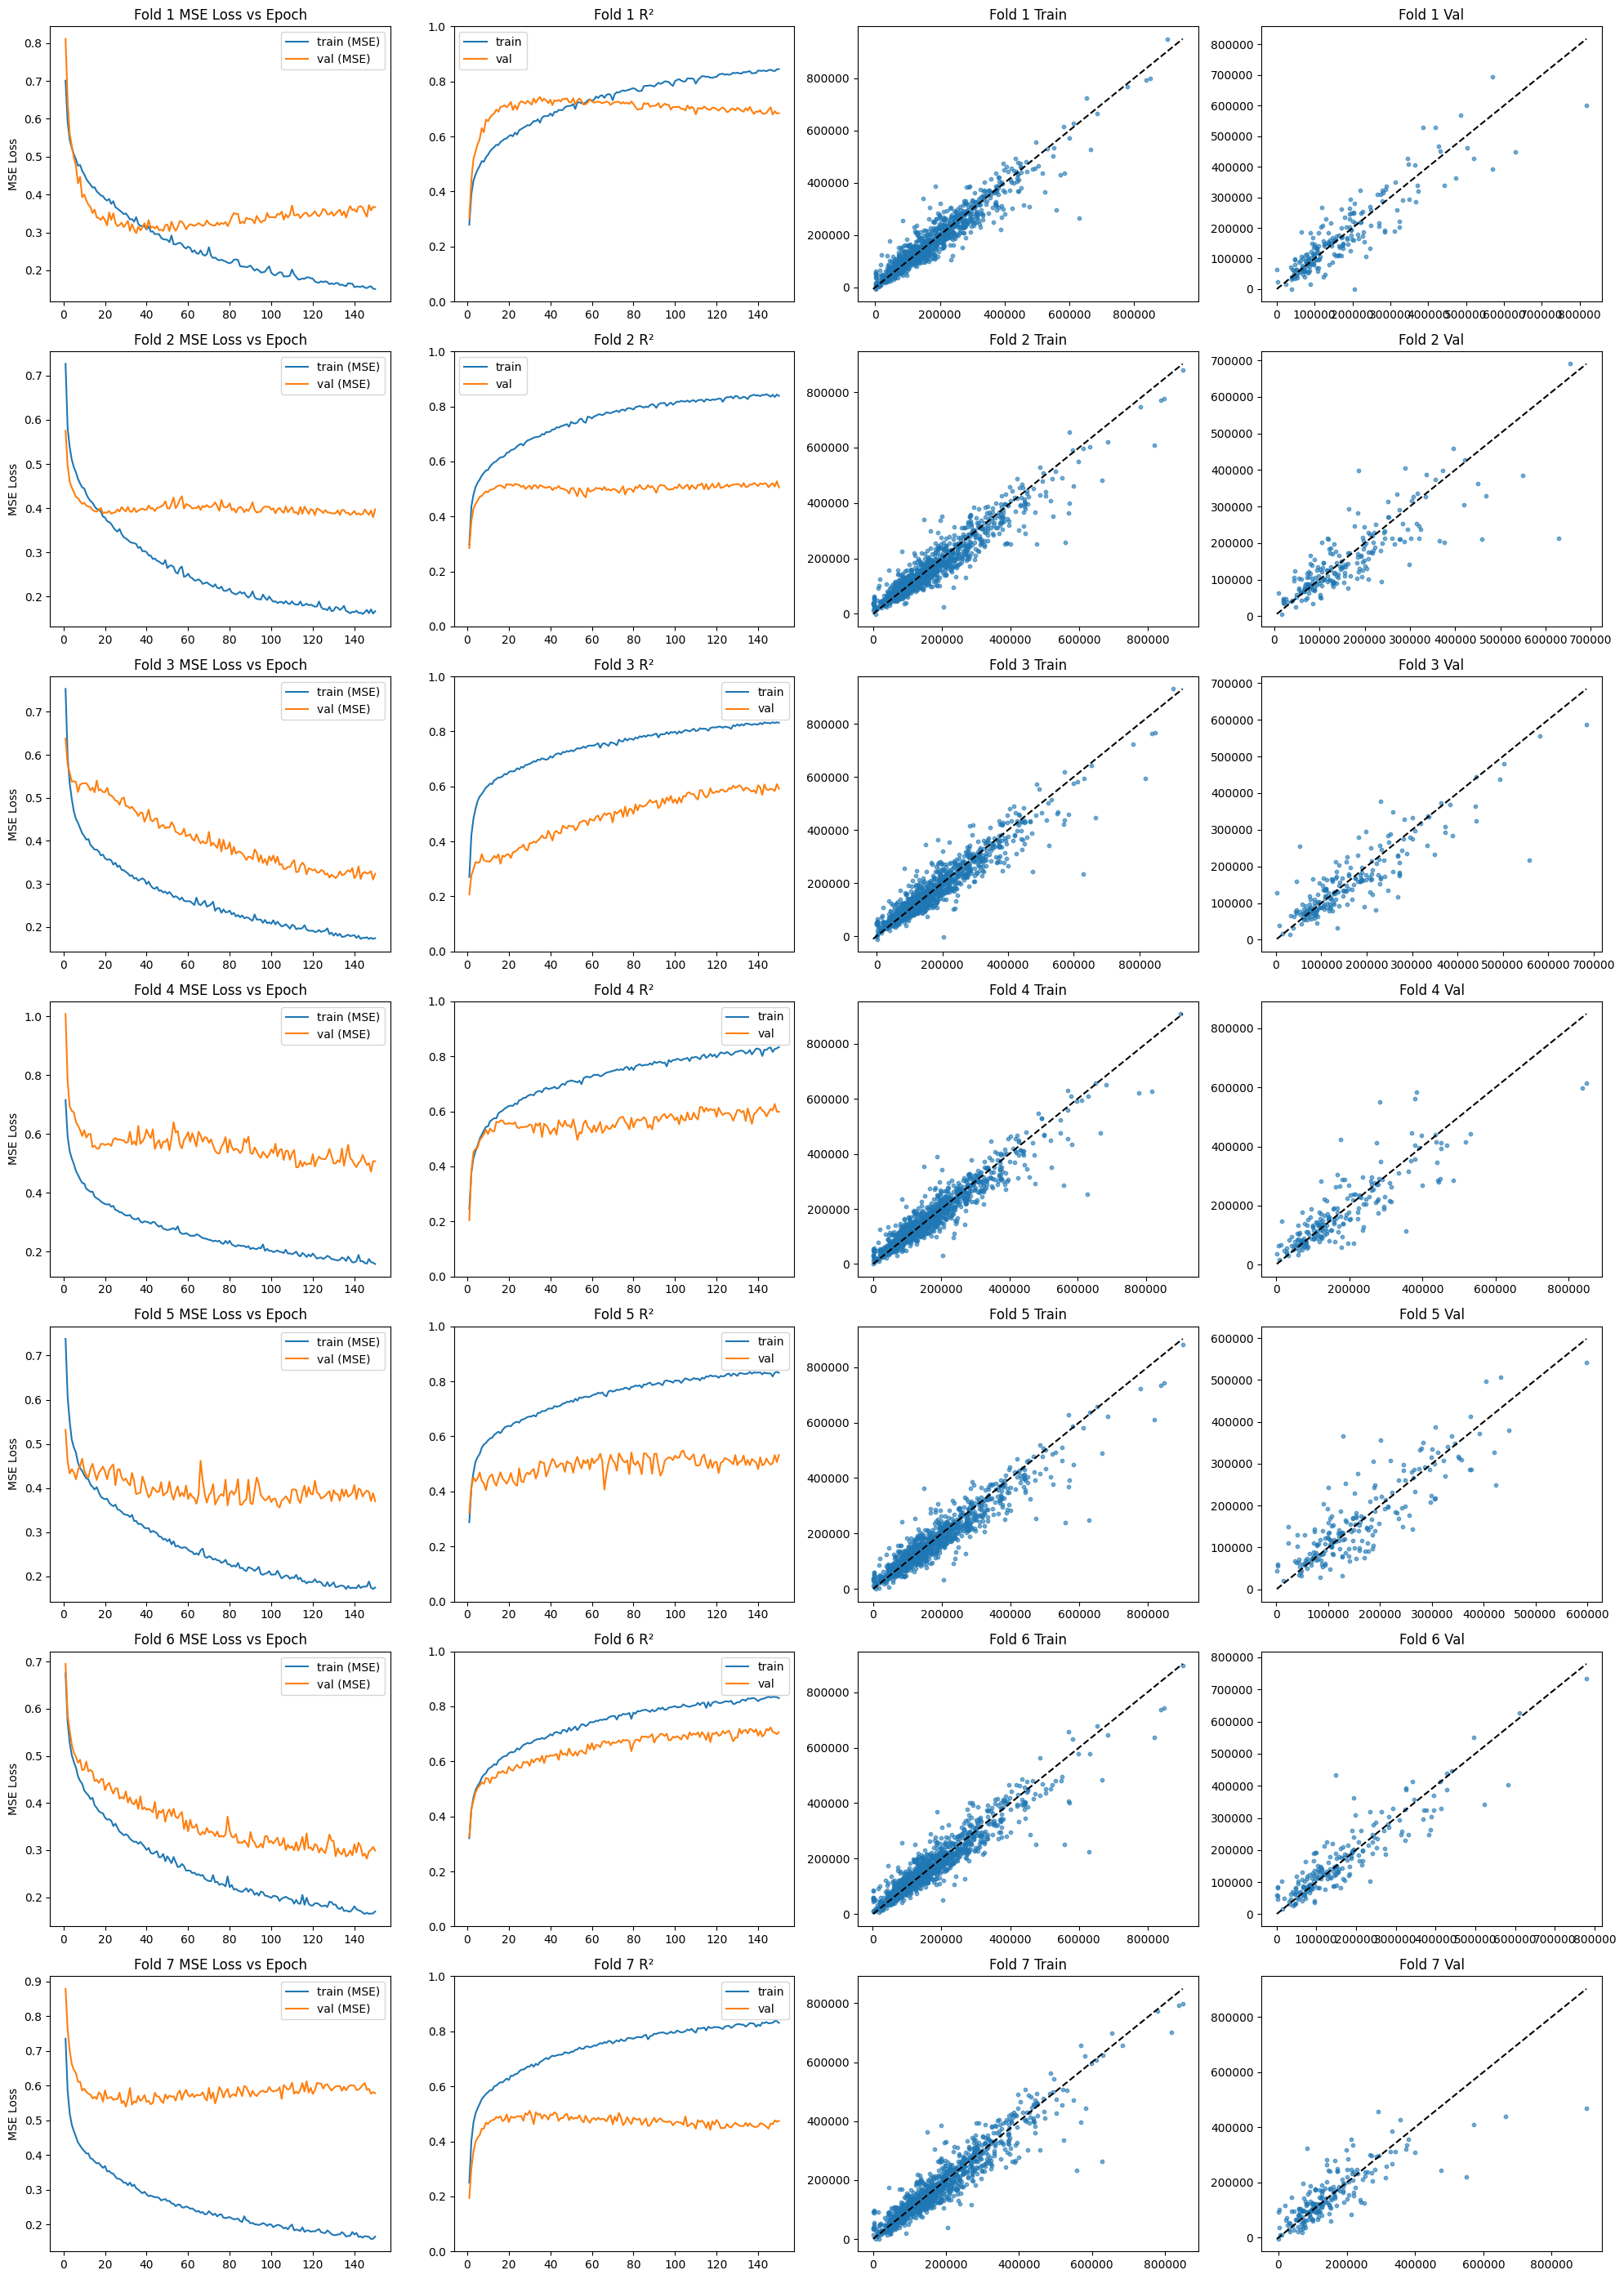

All outputs saved in ./5487fb7d/


In [38]:
import os
import uuid
import json
import torch
import matplotlib.pyplot as plt

# assume cross_validate_mlp is defined above in this script
# from my_module import cross_validate_mlp  

if __name__ == '__main__':
    # Hyperparameters
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv'
    k_folds       = 7
    layer_dims    = [128, 64]
    activations   = ['tanh', 'relu']
    epochs        = 150
    lr            = 5e-4
    weight_decay  = 20e-5
    batch_size    = 16
    random_state  = 42
    loss_type     = 'huber' 

    # 1) Run cross-validation
    folds, histories, models, norms, feature_names = cross_validate_mlp(
        csv_path,
        k_folds,
        layer_dims,
        activations,
        epochs,
        lr,
        weight_decay,
        batch_size,
        random_state,
        loss_type
    )

    # 2) Create a random tag folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # 3) Save each fold's model
    for i, model in enumerate(models, start=1):
        model_path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), model_path)

    # 4) Save hyperparameters
    hyperparams = {
        "csv_path":      csv_path,
        "k_folds":       k_folds,
        "layer_dims":    layer_dims,
        "activations":   activations,
        "epochs":        epochs,
        "lr":            lr,
        "weight_decay":  weight_decay,
        "batch_size":    batch_size,
        "random_state":  random_state,
        "loss_type":     loss_type
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # 5) Save normalization constants
    safe_norms = {
        'y_mean':   norms['y_mean'],
        'y_std':    norms['y_std'],
        'x_mean':   norms['x_mean'],
        'x_std':    norms['x_std'],
    }
    with open(os.path.join(tag, f"{tag}_norms.json"), "w") as f:
        json.dump(safe_norms, f, indent=4)

    # 6) Plot diagnostics for each fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, folds)):
        ax1, ax2, ax3, ax4 = axes[i]

        # a) MSE Loss vs Epoch
        ax1.plot(range(1, epochs+1), tr_losses, label='train (MSE)')
        ax1.plot(range(1, epochs+1), va_losses, label='val (MSE)')
        ax1.set_title(f'Fold {fr["fold"]} MSE Loss vs Epoch')
        ax1.set_ylabel('MSE Loss')
        ax1.legend()


        # b) R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2s, label='train')
        ax2.plot(range(1, epochs+1), va_r2s, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R²')
        ax2.set_ylim(0, 1)        # <— force y‐axis between 0 and 1
        ax2.legend()


        # c) Train True vs Pred (rescale)
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        lim_tr = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        ax3.plot(lim_tr, lim_tr, 'k--')
        ax3.set_title(f'Fold {fr["fold"]} Train')

        # d) Val True vs Pred (rescale)
        yt_va = fr['val_true'] * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred'] * norms['y_std'] + norms['y_mean']
        lim_va = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        ax4.plot(lim_va, lim_va, 'k--')
        ax4.set_title(f'Fold {fr["fold"]} Val')

    plt.tight_layout()
    # 7) Save diagnostics plot
    plt.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs saved in ./{tag}/")


## Third: Increased Nurans

Fold 1: train MSE=0.1349, train R²=0.8613, val   MSE=0.3316, val   R²=0.7146
Fold 2: train MSE=0.1541, train R²=0.8509, val   MSE=0.3909, val   R²=0.5134
Fold 3: train MSE=0.1445, train R²=0.8602, val   MSE=0.3136, val   R²=0.6046
Fold 4: train MSE=0.1437, train R²=0.8487, val   MSE=0.3959, val   R²=0.6876
Fold 5: train MSE=0.1471, train R²=0.8580, val   MSE=0.3543, val   R²=0.5515
Fold 6: train MSE=0.1567, train R²=0.8426, val   MSE=0.2783, val   R²=0.7268
Fold 7: train MSE=0.1328, train R²=0.8642, val   MSE=0.5637, val   R²=0.4852


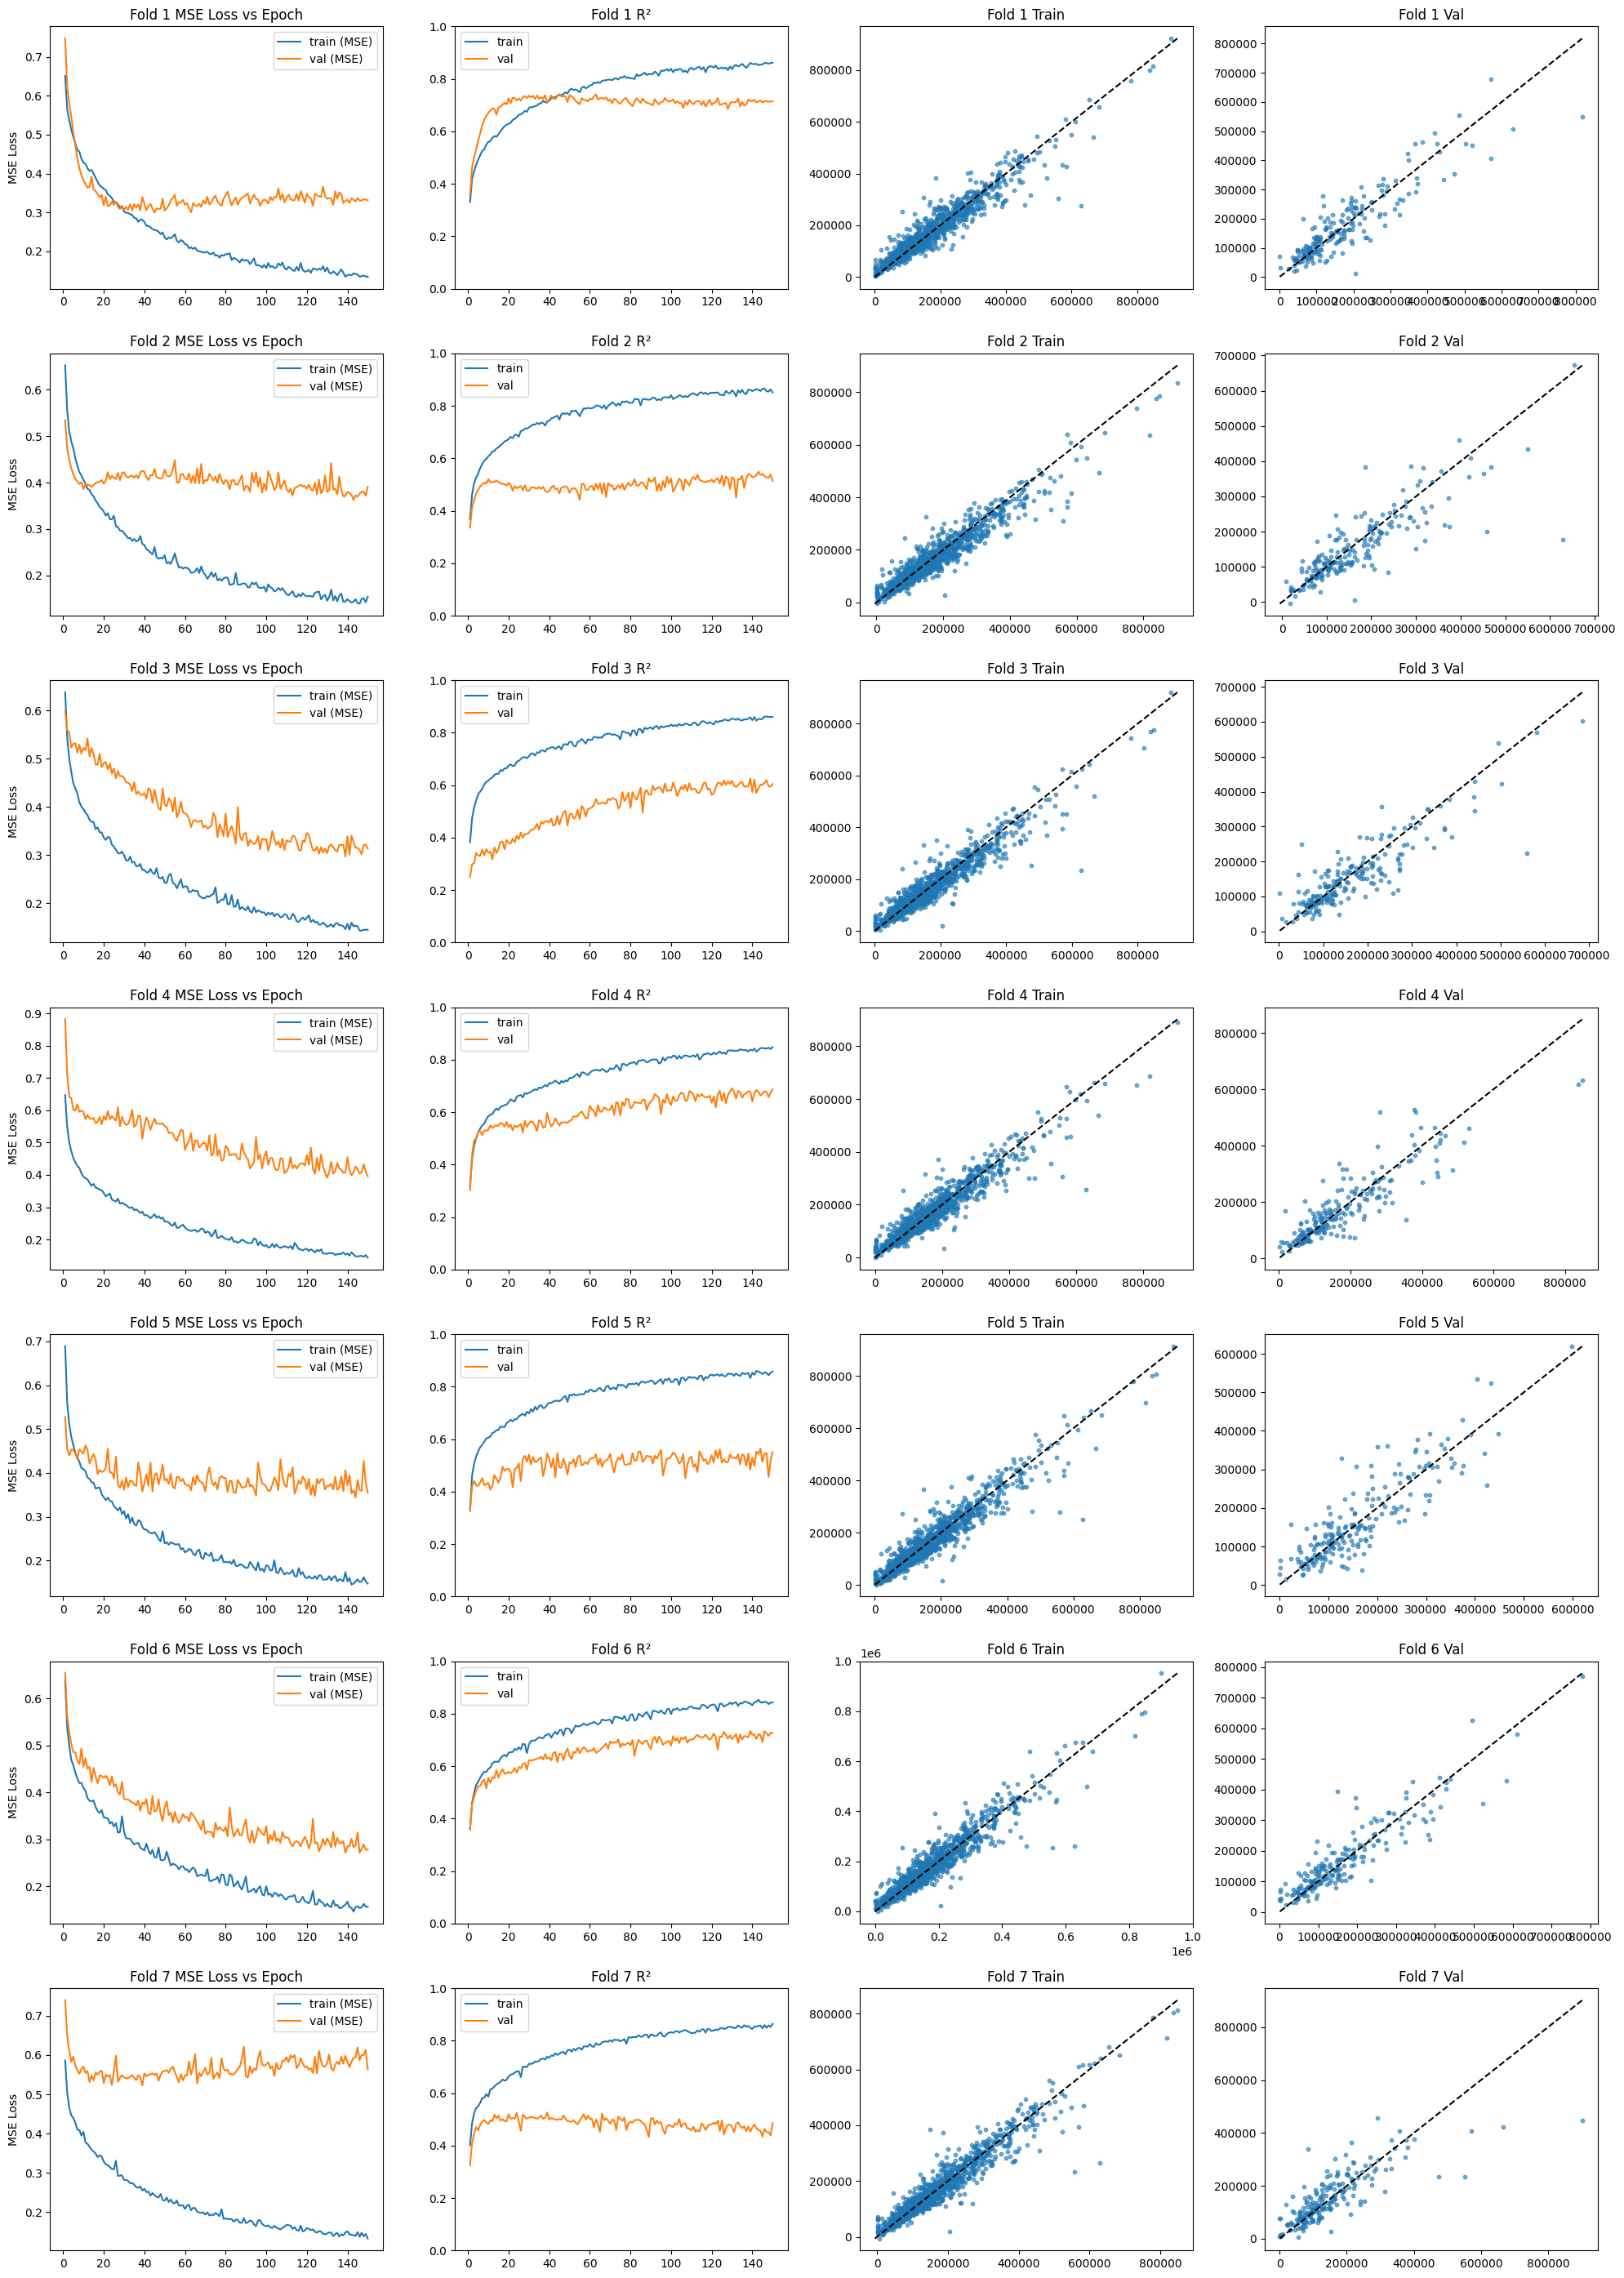

All outputs saved in ./606d04aa/


In [43]:
import os
import uuid
import json
import torch
import matplotlib.pyplot as plt

# assume cross_validate_mlp is defined above in this script
# from my_module import cross_validate_mlp  

if __name__ == '__main__':
    # Hyperparameters
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv'
    k_folds       = 7
    layer_dims    = [128, 128]
    activations   = ['tanh', 'relu']
    epochs        = 150
    lr            = 5e-4
    weight_decay  = 20e-5
    batch_size    = 16
    random_state  = 42
    loss_type     = 'huber' 

    # 1) Run cross-validation
    folds, histories, models, norms, feature_names = cross_validate_mlp(
        csv_path,
        k_folds,
        layer_dims,
        activations,
        epochs,
        lr,
        weight_decay,
        batch_size,
        random_state,
        loss_type
    )

    # 2) Create a random tag folder
    tag = uuid.uuid4().hex[:8]
    os.makedirs(tag, exist_ok=True)

    # 3) Save each fold's model
    for i, model in enumerate(models, start=1):
        model_path = os.path.join(tag, f"{tag}_fold{i}.pth")
        torch.save(model.state_dict(), model_path)

    # 4) Save hyperparameters
    hyperparams = {
        "csv_path":      csv_path,
        "k_folds":       k_folds,
        "layer_dims":    layer_dims,
        "activations":   activations,
        "epochs":        epochs,
        "lr":            lr,
        "weight_decay":  weight_decay,
        "batch_size":    batch_size,
        "random_state":  random_state,
        "loss_type":     loss_type
    }
    with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
        json.dump(hyperparams, f, indent=4)

    # 5) Save normalization constants
    safe_norms = {
        'y_mean':   norms['y_mean'],
        'y_std':    norms['y_std'],
        'x_mean':   norms['x_mean'],
        'x_std':    norms['x_std'],
    }
    with open(os.path.join(tag, f"{tag}_norms.json"), "w") as f:
        json.dump(safe_norms, f, indent=4)

    # 6) Plot diagnostics for each fold
    fig, axes = plt.subplots(k_folds, 4, figsize=(20, 4*k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, folds)):
        ax1, ax2, ax3, ax4 = axes[i]

        # a) MSE Loss vs Epoch
        ax1.plot(range(1, epochs+1), tr_losses, label='train (MSE)')
        ax1.plot(range(1, epochs+1), va_losses, label='val (MSE)')
        ax1.set_title(f'Fold {fr["fold"]} MSE Loss vs Epoch')
        ax1.set_ylabel('MSE Loss')
        ax1.legend()


        # b) R² vs Epoch
        ax2.plot(range(1, epochs+1), tr_r2s, label='train')
        ax2.plot(range(1, epochs+1), va_r2s, label='val')
        ax2.set_title(f'Fold {fr["fold"]} R²')
        ax2.set_ylim(0, 1)        # <— force y‐axis between 0 and 1
        ax2.legend()


        # c) Train True vs Pred (rescale)
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        lim_tr = [min(yt_tr.min(), yp_tr.min()), max(yt_tr.max(), yp_tr.max())]
        ax3.scatter(yt_tr, yp_tr, s=10, alpha=0.6)
        ax3.plot(lim_tr, lim_tr, 'k--')
        ax3.set_title(f'Fold {fr["fold"]} Train')

        # d) Val True vs Pred (rescale)
        yt_va = fr['val_true'] * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred'] * norms['y_std'] + norms['y_mean']
        lim_va = [min(yt_va.min(), yp_va.min()), max(yt_va.max(), yp_va.max())]
        ax4.scatter(yt_va, yp_va, s=10, alpha=0.6)
        ax4.plot(lim_va, lim_va, 'k--')
        ax4.set_title(f'Fold {fr["fold"]} Val')

    plt.tight_layout()
    # 7) Save diagnostics plot
    plt.savefig(os.path.join(tag, f"{tag}_diagnostics.png"))
    plt.show()

    print(f"All outputs saved in ./{tag}/")
